# LightGBM 

This notebook will be used to tune and evaluate the LightGBM model.

We will tune the model hyperparameters using crossvalidation, using two different scores: balanced_accuracy and f1_weighted. We also have a variable 'noise_event_laeq_primary_detected_certainty' which accounts for how certain it is that a noise was labeled correctly. We will consider models with and without these variable. 

Therefore, we need to tune and evaluate four different scenarios:
- certainty + balanced_accuracy
- certainty + f1_weighted
- no certainty + balanced_accuracy
- no certainty + f1_weighted

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.model_datatransforms import *

---
## Data Loading

In [2]:
df = pd.read_parquet('data/pred_model_data_full.parquet')

In [3]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

Since we have fewer observations for 'Music non-amplified' and 'Nature elements - Wind', we will join these classes to 'Unsupported' 

In [4]:
conditions = df['noise_event_laeq_primary_detected_class'].isin(['Music non-amplified', 'Nature elements - Wind', 'Unsupported'])
df.loc[conditions, 'noise_event_laeq_primary_detected_class'] = 'Other'

df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Other                             21030
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [5]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class']) 

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Convert 'noise_event_laeq_primary_detected_certainty' to values between 0 and 1

In [6]:
X['noise_event_laeq_primary_detected_certainty']=X['noise_event_laeq_primary_detected_certainty']/100
X.noise_event_laeq_primary_detected_certainty

0        0.97
1        0.78
2        0.98
3        1.00
4        1.00
         ... 
77227    0.96
77228    0.98
77229    0.85
77230    0.00
77231    0.00
Name: noise_event_laeq_primary_detected_certainty, Length: 77232, dtype: float64

---
# Certainty + balanced_accuracy

In [37]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [38]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.813710852911837

In [39]:
#choose the parameters
n_estimators = np.arange(30,60,10)
learning_rate = np.array([0.05,0.1,0.2])
num_leaves = np.arange(20,60,10)
min_child_samples=np.arange(5,25,5)

params_grid = {
    'month_handler__strategy': ['month', 'season'], 
    'day_of_the_week_handler__strategy': ['full', 'weekend'], 
    'custom_encoder__strategy': ['one_hot', 'binary'], 
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples
}

In [40]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=100, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.8276938543635536
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 20, 'lightgbm__n_estimators': 50, 'lightgbm__min_child_samples': 10, 'lightgbm__learning_rate': 0.1, 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [41]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=20, n_estimators=50, min_child_samples=10, learning_rate=0.1))
])

In [42]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lamax_shift_t-_3', 'laeq_shift_t-_3',
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                       

In [43]:
y_pred = pipeline.predict(X_test)

In [44]:
y_pred_proba = pipeline.predict_proba(X_test)

In [45]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.8839447561501942
Balanced Accuracy: 0.830110504474189


In [46]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9670147280859416

In [47]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

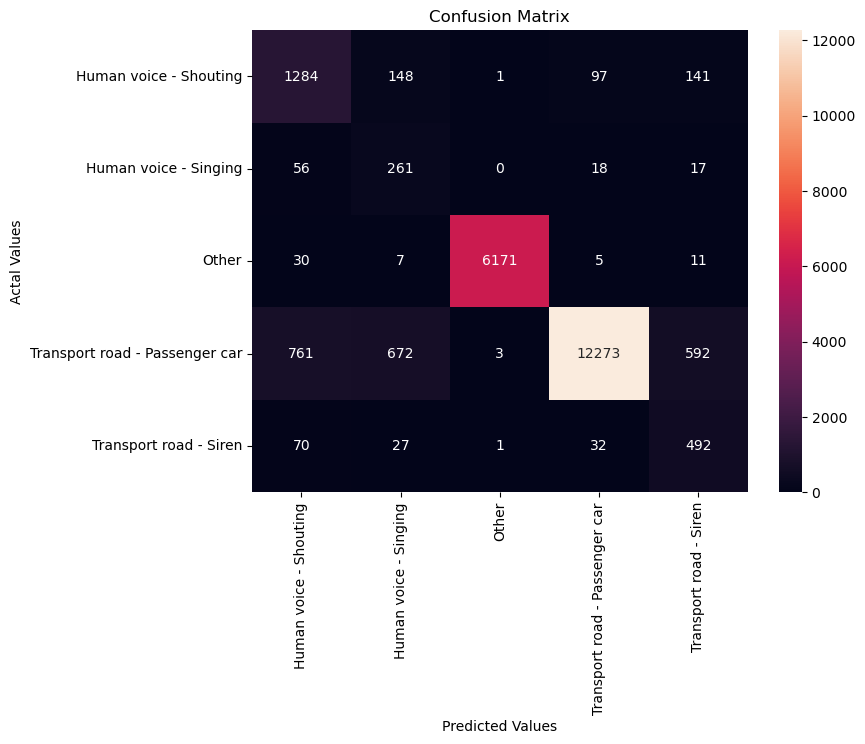

In [48]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')


plt.show()

In [49]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.58      0.77      0.66      1671
         Human voice - Singing       0.23      0.74      0.36       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.99      0.86      0.92     14301
        Transport road - Siren       0.39      0.79      0.52       622

                      accuracy                           0.88     23170
                     macro avg       0.64      0.83      0.69     23170
                  weighted avg       0.93      0.88      0.90     23170



---
# Certainty + F1-weighted

In [76]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [77]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.9293563890101716

In [78]:
#choose the parameters
n_estimators = np.arange(300,550,50)
learning_rate = np.array([0.1,0.2,0.3])
num_leaves = np.arange(30,80,10)
min_child_samples=np.arange(15,35,5)

params_grid = {
    'month_handler__strategy': ['month',,'season'],
    'day_of_the_week_handler__strategy': ['full', 'weekend'], 
    'custom_encoder__strategy': ['one_hot','binary'], 
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples
}

In [79]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=200, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.9491873537189006
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 50, 'lightgbm__n_estimators': 300, 'lightgbm__min_child_samples': 30, 'lightgbm__learning_rate': 0.3, 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [80]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=50, n_estimators=300, min_child_samples=30, learning_rate=0.3))
])

In [81]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                                         'lamax_shift_t-_3', 'laeq_shift_t-_3',
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                       

In [82]:
y_pred = pipeline.predict(X_test)

In [83]:
y_pred_proba = pipeline.predict_proba(X_test)

In [84]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.953258523953388
Balanced Accuracy: 0.7678407879419185


In [85]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9666319295370345

In [86]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

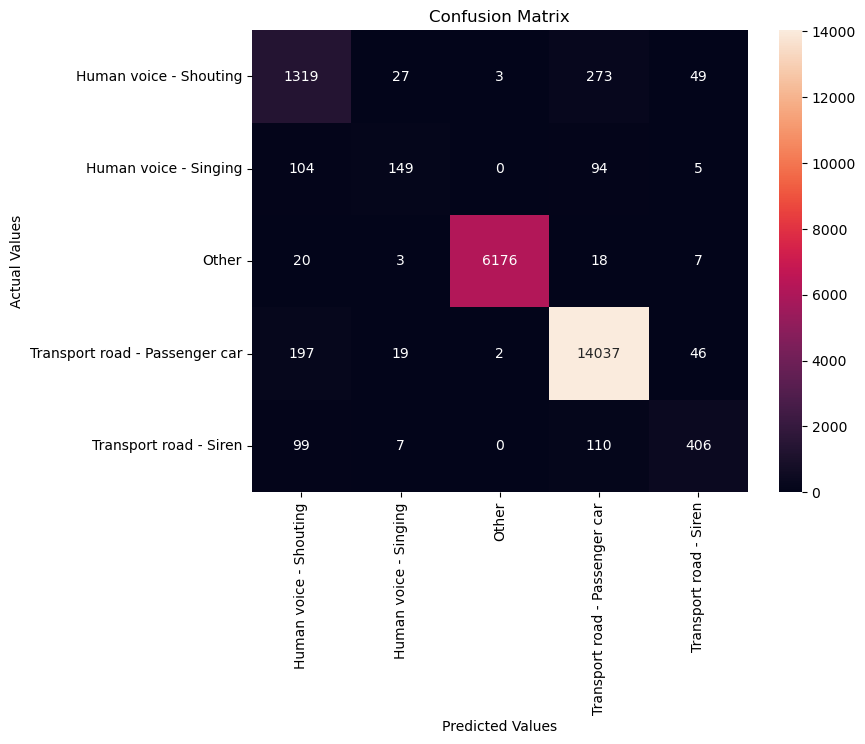

In [87]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [88]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.76      0.79      0.77      1671
         Human voice - Singing       0.73      0.42      0.54       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.97      0.98      0.97     14301
        Transport road - Siren       0.79      0.65      0.72       622

                      accuracy                           0.95     23170
                     macro avg       0.85      0.77      0.80     23170
                  weighted avg       0.95      0.95      0.95     23170



--- 
# No certainty + balanced_accuracy

We will drop the column 'noise_event_laeq_primary_detected_certainty'

In [149]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [150]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.6330495554559926

In [151]:
#choose the parameters
n_estimators = np.arange(50,100,10)
learning_rate = np.array([0.06,0.08,0.1,0.12])
num_leaves = np.arange(20,40,5)
min_child_samples=np.arange(8,15,3)

params_grid = {
    'month_handler__strategy': ['month','season'],  
    'day_of_the_week_handler__strategy': ['full','weekend'],  
    'custom_encoder__strategy': ['one_hot', 'binary'],
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples
}

In [152]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=150, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.6416150378495377
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 25, 'lightgbm__n_estimators': 80, 'lightgbm__min_child_samples': 11, 'lightgbm__learning_rate': 0.06, 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [153]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=25, n_estimators=80, min_child_samples=11, learning_rate=0.06))
])

In [154]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lamax_shift_t-_3', 'laeq_shift_t-_3',
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_s

In [155]:
y_pred = pipeline.predict(X_test)

In [156]:
y_pred_proba = pipeline.predict_proba(X_test)

In [157]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.653992231333621
Balanced Accuracy: 0.6426044630763984


In [158]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.8900909528466501

In [159]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

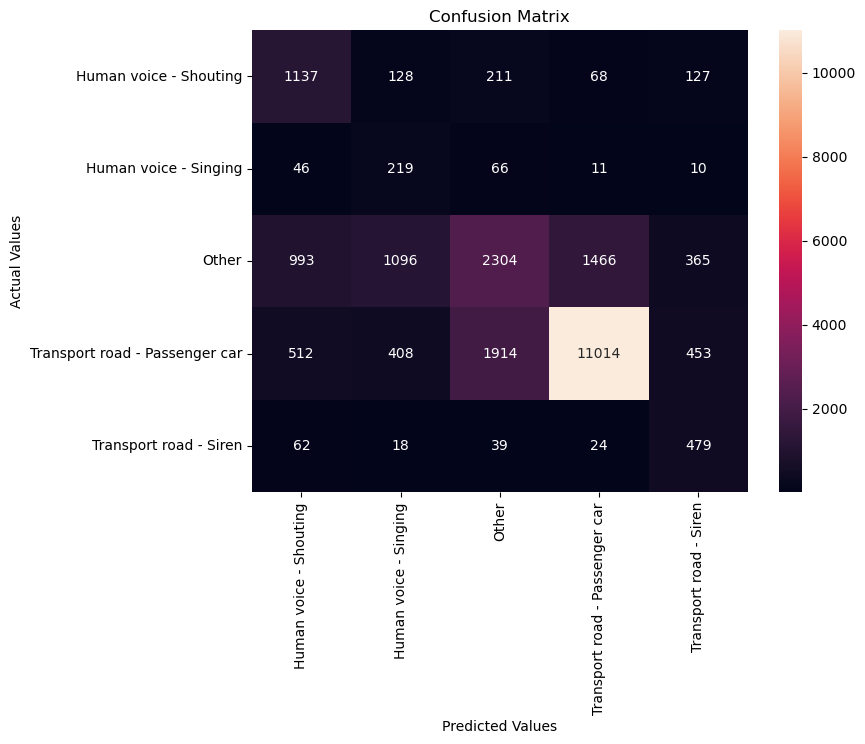

In [160]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [161]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.41      0.68      0.51      1671
         Human voice - Singing       0.12      0.62      0.20       352
                         Other       0.51      0.37      0.43      6224
Transport road - Passenger car       0.88      0.77      0.82     14301
        Transport road - Siren       0.33      0.77      0.47       622

                      accuracy                           0.65     23170
                     macro avg       0.45      0.64      0.49     23170
                  weighted avg       0.72      0.65      0.67     23170



---
# No certainty + F1-weighted

In [163]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced'))
])

In [164]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.7067790941223517

In [166]:
#choose the parameters
n_estimators = np.arange(300,700,100)
learning_rate = np.array([0.05,0.1,0.15])
num_leaves = np.arange(20,60,10)
min_child_samples=np.arange(15,35,5)

params_grid = {
    'month_handler__strategy': ['month','season'],
    'day_of_the_week_handler__strategy': ['full','weekend'],
    'custom_encoder__strategy': ['one_hot','binary'],
    'lightgbm__n_estimators': n_estimators,
    'lightgbm__learning_rate': learning_rate,
    'lightgbm__num_leaves': num_leaves,
    'lightgbm__min_child_samples': min_child_samples
}

In [167]:
cv = KFold(n_splits=3)
search = RandomizedSearchCV(pipeline, param_distributions=params_grid, n_jobs=-1, cv=cv, n_iter=150, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.7450432451230316
Best Parameters: {'month_handler__strategy': 'month', 'lightgbm__num_leaves': 50, 'lightgbm__n_estimators': 500, 'lightgbm__min_child_samples': 15, 'lightgbm__learning_rate': 0.1, 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [168]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot'
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('lightgbm', LGBMClassifier(random_state=42, class_weight='balanced', num_leaves=50, n_estimators=500, min_child_samples=15, learning_rate=0.1))
])

In [169]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                                         'lamax_shift_t-_3', 'laeq_shift_t-_3',
                                         'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
                                         'lamax_shift_t-_4', 'laeq_shift_t-_4',
                                         'lceq_shift_t-_4', 'lcpeak_shift_t-_4',
                                         'lamax_shift_t-_5', 'laeq_s

In [170]:
y_pred = pipeline.predict(X_test)

In [171]:
y_pred_proba = pipeline.predict_proba(X_test)

In [172]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.7499352611135088
Balanced Accuracy: 0.5597973217820698


In [173]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.8800799503278043

In [174]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

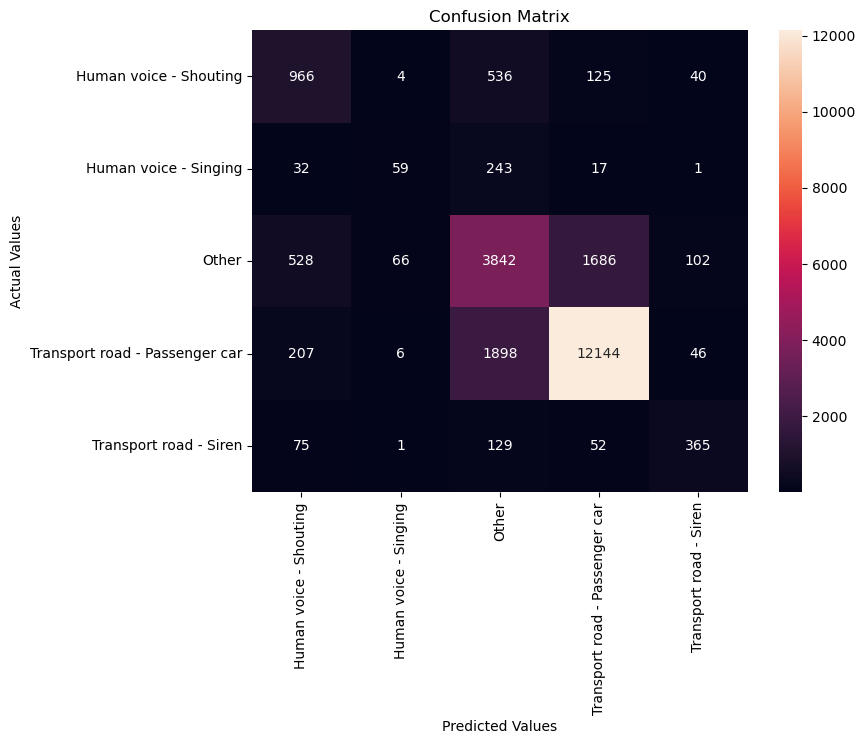

In [175]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [176]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.53      0.58      0.56      1671
         Human voice - Singing       0.43      0.17      0.24       352
                         Other       0.58      0.62      0.60      6224
Transport road - Passenger car       0.87      0.85      0.86     14301
        Transport road - Siren       0.66      0.59      0.62       622

                      accuracy                           0.75     23170
                     macro avg       0.61      0.56      0.57     23170
                  weighted avg       0.75      0.75      0.75     23170

